# 0. Load parameters


In [1]:
# | tags: [parameters]
subject = "101"

In [2]:
#| tags: [parameters]
# Injected Parameters
subject = 152


In [3]:
import os
import mne
from pathlib import Path
from spectral.utils import print_date_time, read_parameters, config_project
from spectral.preproc import load_data, zapline_clean, get_bad_annotations
from spectral.preproc import detrending, apply_pyprep, get_bad_channels
from spectral.viz import plot_step, plot_bad_channels


mne.viz.set_browser_backend("matplotlib")
# mne.viz.set_browser_backend("qt")
mne.set_config("MNE_BROWSER_THEME", "light")
# matplotlib.use("Agg")

config = read_parameters()
my_paths = config_project(subject)

project_path = my_paths["project_path"]
raw_preproc_path = my_paths["raw_preproc_path"]
print(raw_preproc_path)
Path(raw_preproc_path).mkdir(parents=True, exist_ok=True)

figures_path = my_paths["figures_path"]

print_date_time()

Using matplotlib as 2D backend.


/Users/daniel/PhD/Projects/psd-path/analysis/data/raw/sub-152/
2024-03-29 13:25:51


This file contains preprocessing files after downsampling them.


# 1. Preprocess raw data


Loading data from /Users/daniel/PhD/Projects/psd-path/data/raw/BIDS/sub-152/ses-01/eeg/sub-152_ses-01_task-rest_eeg.set


Creating RawArray with float64 data, n_channels=258, n_times=161178


    Range : 0 ... 161177 =      0.000 ...   322.354 secs


Ready.


Detrending done


Filtering raw data in 2 contiguous segments


Setting up band-pass filter from 1 - 1e+02 Hz


FIR filter parameters


---------------------


Designing a one-pass, zero-phase, non-causal bandpass filter:


- Windowed frequency-domain design (firwin2) method


- Hamming window


- Lower passband edge: 1.00


- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)


- Upper passband edge: 100.00 Hz


- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)


- Filter length: 3301 samples (6.602 s)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s


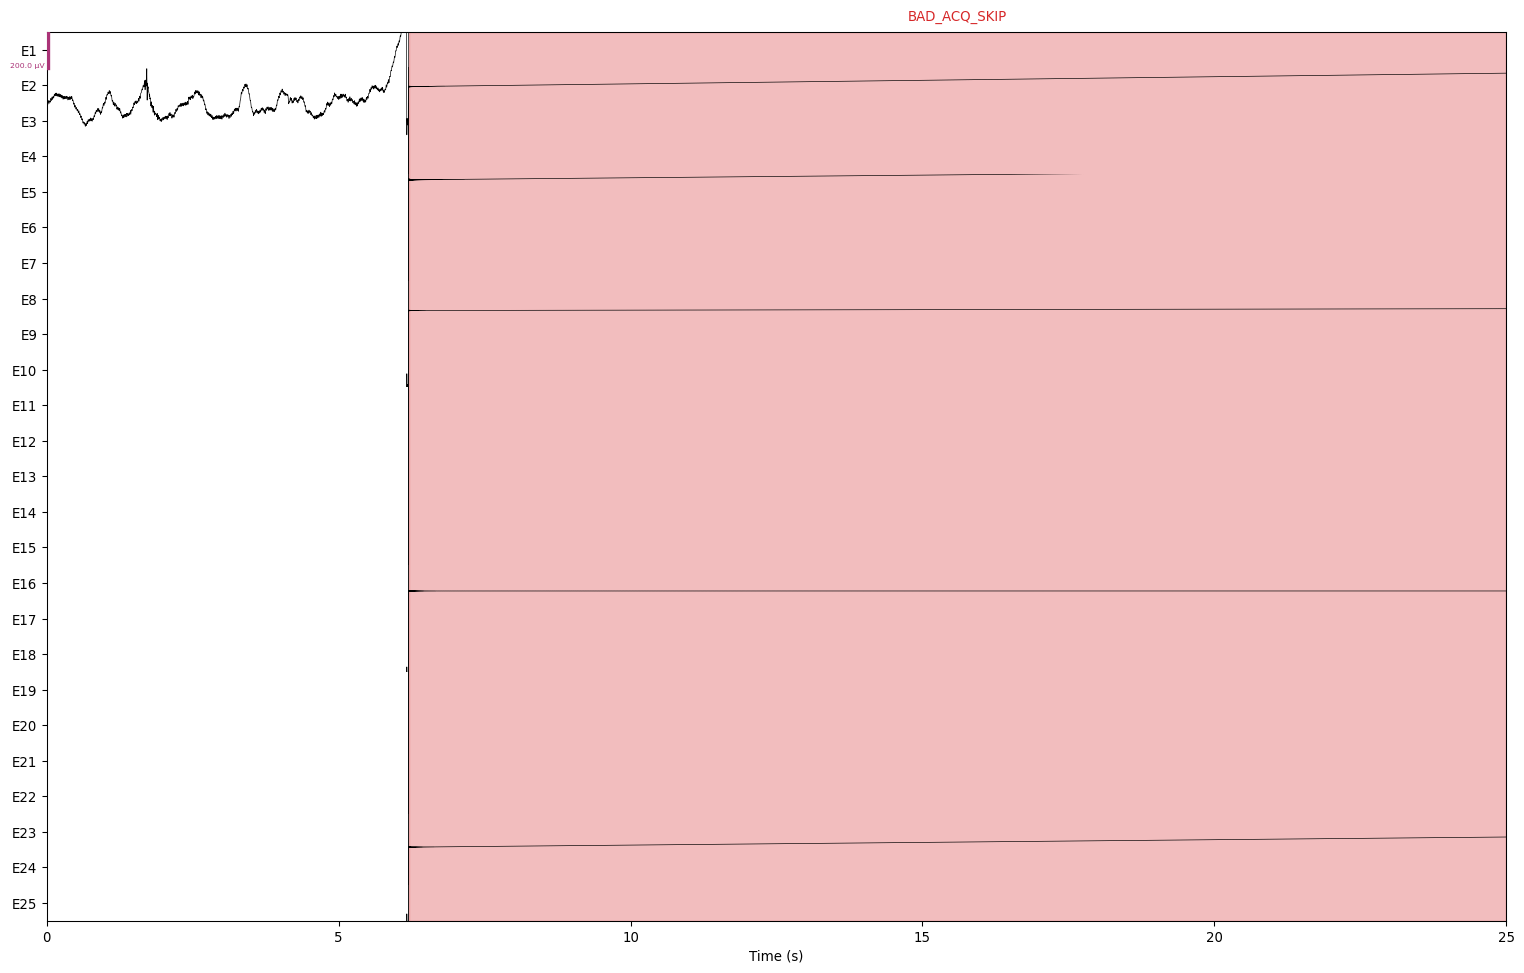

Setting 11317 of 149001 (7.60%) samples to NaN, retaining 137684 (92.40%) samples.


Effective window size : 4.096 (s)


/Users/daniel/.pyenv/versions/conda-paths-3.12/lib/python3.12/site-packages/spectral/viz.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,260 points
Good channels,"256 EEG, 1 ECG"
Bad channels,VREF
EOG channels,Not available
ECG channels,ECG
Sampling frequency,500.00 Hz
Highpass,1.00 Hz
Lowpass,100.00 Hz


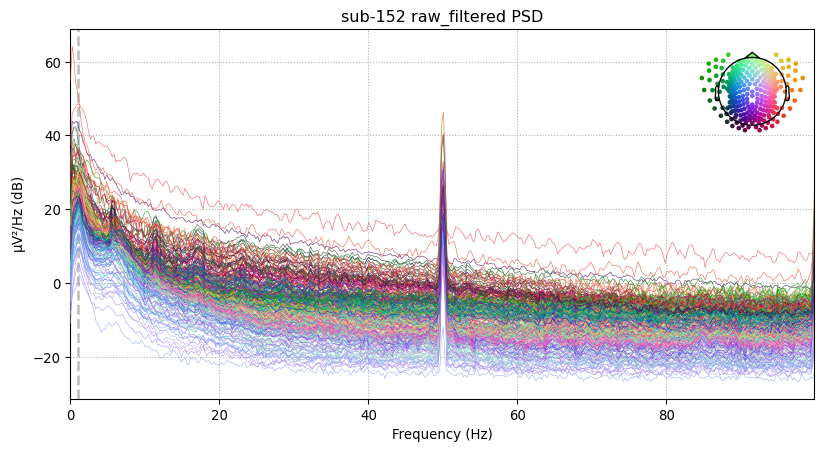

In [4]:
fline = 50
h_freq = 100
notch_freq = 50

filter_params = {
    "l_freq": 1,
    "h_freq": h_freq,
    "h_trans_bandwidth": "auto",
    "fir_window": "hamming",
    "fir_design": "firwin2",
    "phase": "zero",
}


# .notch_filter(freqs=50)  # removedrifts
# print(project_path)
raw = load_data(subject, project_path=project_path)
raw.info["bads"] = ["VREF"]
raw = raw.resample(500)
raw_detrended = detrending(raw)
print("Detrending done")

raw_filtered = (
    raw_detrended.copy()
    .crop(tmin=2, tmax=300, include_tmax=True)
    .filter(**filter_params)
)

plot_step(
    raw_filtered,
    subject,
    figures_path,
    stage="raw_filtered",
    duration=25.0,
    n_channels=25,
    fmax=h_freq,
)

raw_filtered.info

Power of components removed by DSS: 0.00


Iteration 0 score: 2.2602348452851056e-12


Power of components removed by DSS: 0.00


Iteration 1 score: -6.459480158490818e-13


Power of components removed by DSS: 0.00


Iteration 0 score: -8.59426922439839e-13


Power of components removed by DSS: 0.00


Iteration 0 score: -9.26313660170616e-13


Power of components removed by DSS: 0.00


Iteration 0 score: -9.523092418466723e-13
Creating RawArray with float64 data, n_channels=258, n_times=149001


    Range : 0 ... 149000 =      0.000 ...   298.000 secs


Ready.


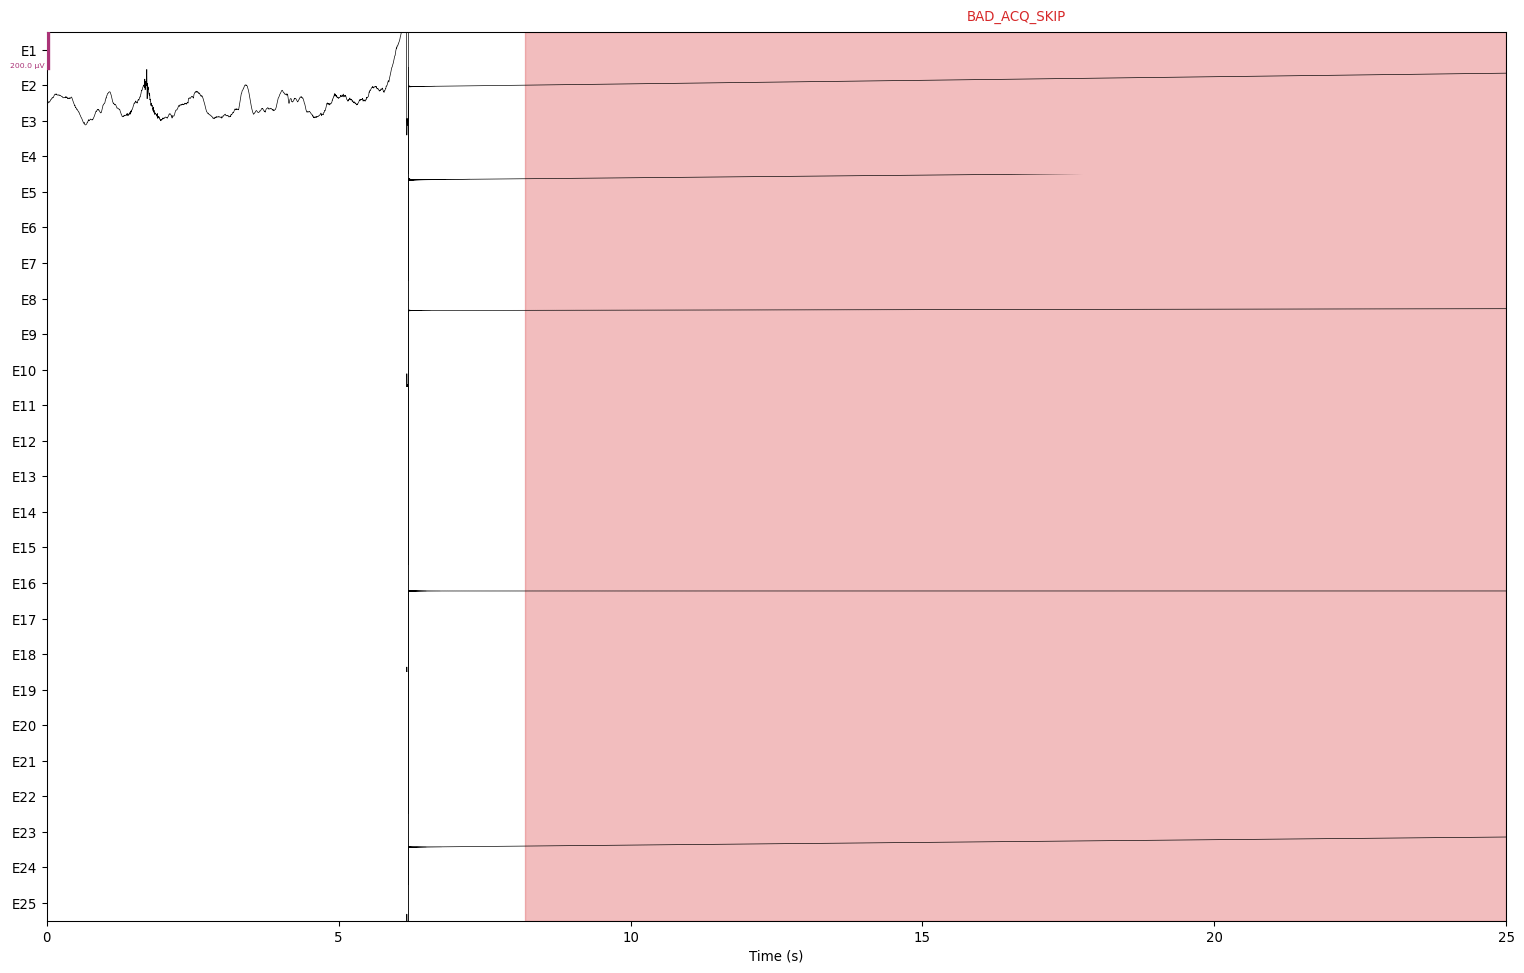

Setting 11317 of 149001 (7.60%) samples to NaN, retaining 137684 (92.40%) samples.


Effective window size : 4.096 (s)


/Users/daniel/.pyenv/versions/conda-paths-3.12/lib/python3.12/site-packages/spectral/viz.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


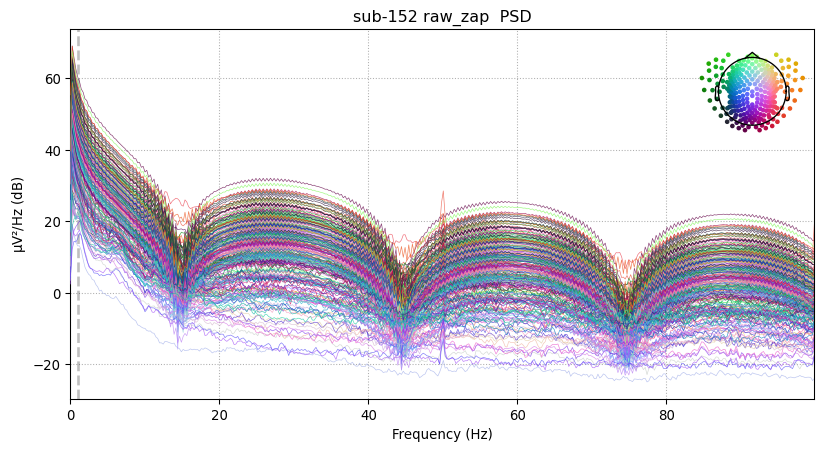

In [5]:
iter_param = {
    "nfft": 500,
    "n_iter_max": 200,
    "win_sz": 12.5,
    "spot_sz": 6,
}
raw_zap = zapline_clean(raw_filtered, fline,
                        method="iter", iter_param=iter_param)

plot_step(
    raw_zap,
    subject,
    figures_path,
    stage="raw_zap ",
    duration=25.0,
    n_channels=25,
    fmax=h_freq,
)

In [6]:
pyprep = True

if pyprep:
    bad_channels_by_ransac = apply_pyprep(
        raw_zap, output="dict", as_dict=True
    )
else:
    bad_channels_by_ransac = get_bad_channels(raw_zap)


raw_zap.info["bads"].extend(bad_channels_by_ransac["bad_all"])

annot = get_bad_annotations(
    raw_zap, peak_threshold=2.5, epoch_duration=1.0, extend_bad_duration=1.5
)
raw_annotated = raw_filtered.copy().set_annotations(annot)

raw_annotated.save(
    f"{raw_preproc_path}/sub-{subject}_filtered_zap_eeg.fif", overwrite=True
)
raw_annotated.info

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


Setting up high-pass filter at 1 Hz


FIR filter parameters


---------------------


Designing a one-pass, zero-phase, non-causal highpass filter:


- Windowed time-domain design (firwin) method


- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation


- Lower passband edge: 1.00


- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)


- Filter length: 413 samples (3.304 s)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Executing RANSAC
This may take a while, so be patient...


Finding optimal chunk size : 243


Total # of chunks: 1


Current chunk:


1



RANSAC done!


0.00019287940611004365
Finding segments below or above PTP threshold.


Writing /Users/daniel/PhD/Projects/psd-path/analysis/data/raw/sub-152/sub-152_filtered_zap_eeg.fif


Closing /Users/daniel/PhD/Projects/psd-path/analysis/data/raw/sub-152/sub-152_filtered_zap_eeg.fif


[done]


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,260 points
Good channels,"256 EEG, 1 ECG"
Bad channels,VREF
EOG channels,Not available
ECG channels,ECG
Sampling frequency,500.00 Hz
Highpass,1.00 Hz
Lowpass,100.00 Hz


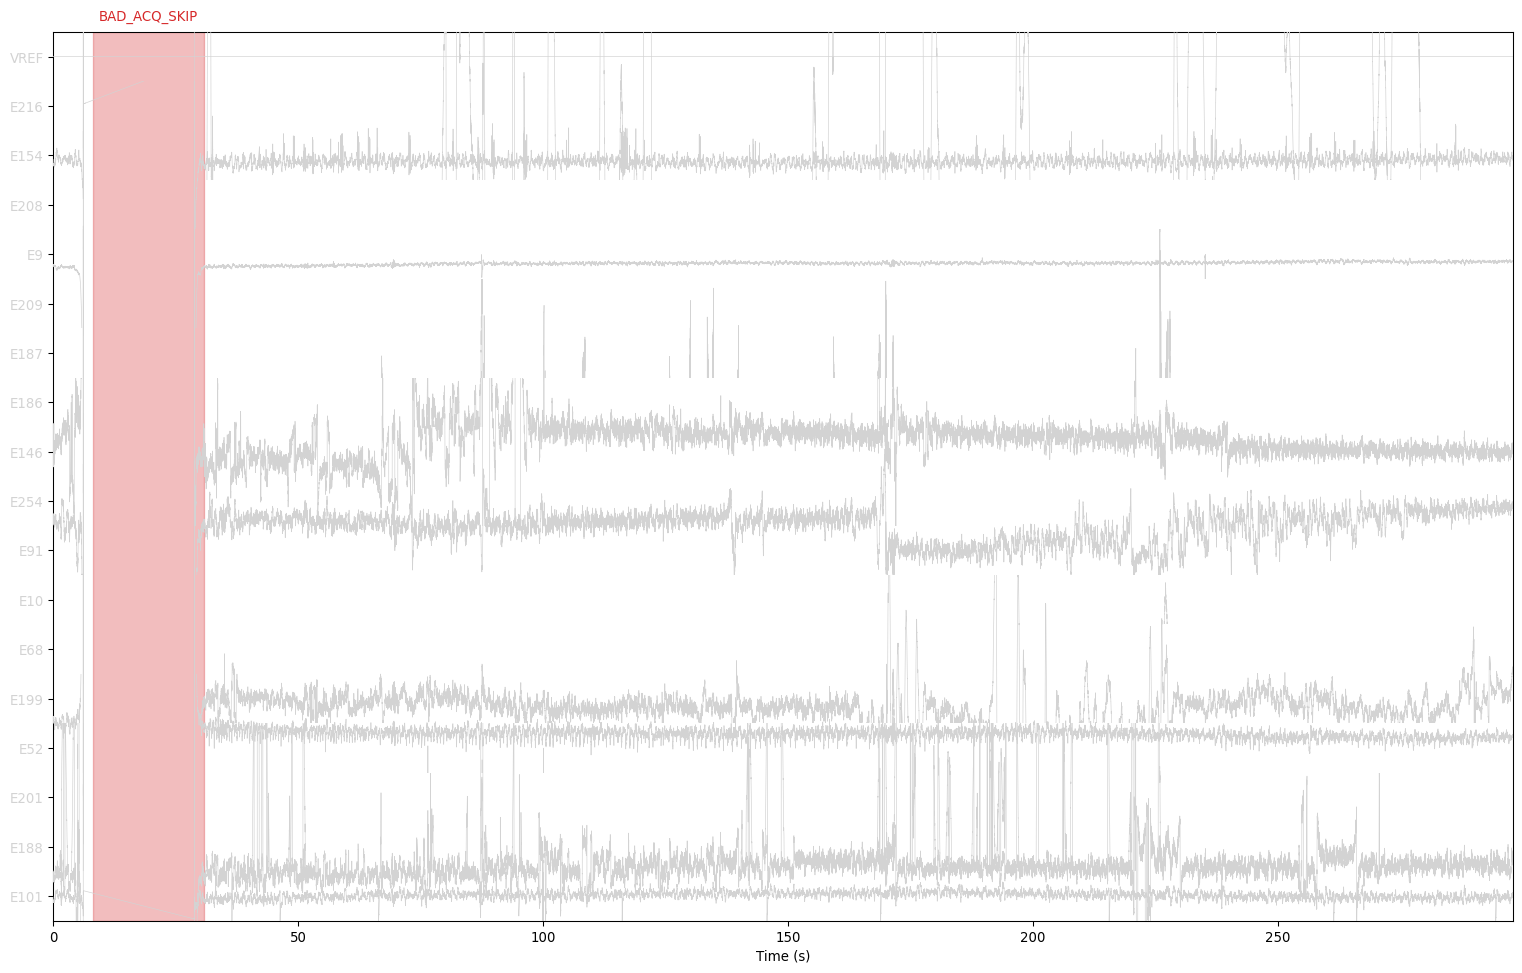

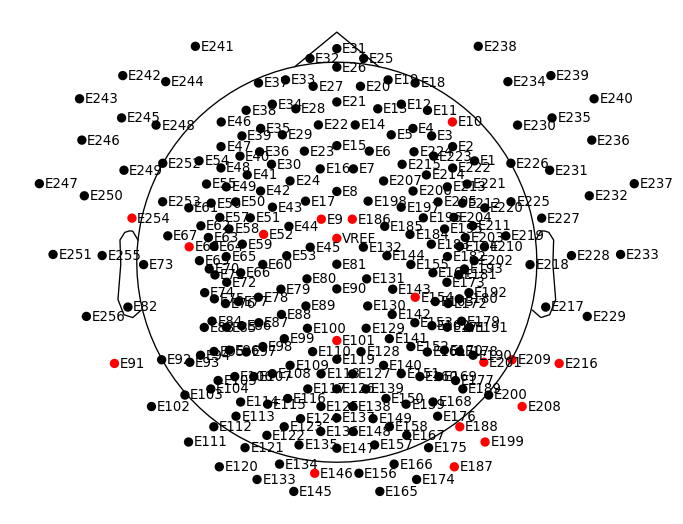

In [7]:
_ = plot_bad_channels(raw_zap, subject, figures_path=figures_path)

In [8]:
print(
    f"{subject} -  identified {len(raw_zap.info['bads'])
                               }  bad channels: {raw_zap.info['bads']}"
)
print_date_time()

152 -  identified 18  bad channels: ['VREF', 'E216', 'E154', 'E208', 'E9', 'E209', 'E187', 'E186', 'E146', 'E254', 'E91', 'E10', 'E68', 'E199', 'E52', 'E201', 'E188', 'E101']
2024-03-29 13:27:18
